In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/My all files /Data Set MINI Project/Dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/CANCER/aug_16_322.jpg  
  inflating: Dataset/CANCER/aug_16_3896.jpg  
  inflating: Dataset/CANCER/aug_16_8259.jpg  
  inflating: Dataset/CANCER/aug_16_8755.jpg  
  inflating: Dataset/CANCER/aug_160_2281.jpg  
  inflating: Dataset/CANCER/aug_160_7507.jpg  
  inflating: Dataset/CANCER/aug_160_8596.jpg  
  inflating: Dataset/CANCER/aug_161_2747.jpg  
  inflating: Dataset/CANCER/aug_161_7194.jpg  
  inflating: Dataset/CANCER/aug_161_8598.jpg  
  inflating: Dataset/CANCER/aug_162_2877.jpg  
  inflating: Dataset/CANCER/aug_162_5192.jpg  
  inflating: Dataset/CANCER/aug_162_8236.jpg  
  inflating: Dataset/CANCER/aug_162_886.jpg  
  inflating: Dataset/CANCER/aug_163_4666.jpg  
  inflating: Dataset/CANCER/aug_163_5380.jpg  
  inflating: Dataset/CANCER/aug_163_6356.jpg  
  inflating: Dataset/CANCER/aug_164_1041.jpg  
  inflating: Dataset/CANCER/aug_164_3991.jpg  
  inflating: Dataset/CANCER/aug_165_3267.jpg  
  inflating: Da

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [ ]:
ROOT_DIR = "/content/Dataset"
number_of_Images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_Images[dir] = len(os.listdir(os.path.join(ROOT_DIR,dir)))

number_of_Images.items()


dict_items([('CANCER', 2698), ('NONCANCER', 2494)])

In [ ]:
def dataFolder(p, split):
    if not os.path.exists("./" + p):
        os.mkdir("./" + p)
        for dir in os.listdir(ROOT_DIR):
            os.makedirs("./" + p + "/" + dir)
        for dir in os.listdir(ROOT_DIR):
            for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR, dir)),
                                        size=(math.floor(split * number_of_Images[dir]) - 5),
                                        replace=False):
                O = os.path.join(ROOT_DIR, dir, img)
                D = os.path.join("./" + p, dir)
                shutil.copy(O, D)
                os.remove(O)
    else:
        print(f'{p}Folder exists')

In [ ]:
dataFolder("train",0.7)

In [ ]:
dataFolder("val",0.15)

In [ ]:
dataFolder("test",0.15)

**Model Build**

In [ ]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras

In [ ]:
# Define the CNN model with added strategies
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(244, 244, 3)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=1, activation='sigmoid'))


In [ ]:
# Compile the model with a learning rate scheduler
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

**Prepare our data using Data Generator**

In [ ]:
# Modify the data generators to include more augmentation techniques
def preprocessingImages(path):
    image_data = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    image_generator = image_data.flow_from_directory(
        directory=path,
        target_size=(244, 244),
        batch_size=32,
        class_mode='binary'
    )
    return image_generator

In [ ]:
path = "/content/train"
train_data = preprocessingImages(path)

Found 3623 images belonging to 2 classes.


In [ ]:
def preprocessingIMages2(path):
  """
  input : Path
  output : Pre processed images
  """

  image_data = ImageDataGenerator(rescale=1/255)
  image = image_data.flow_from_directory(directory = path,target_size = (244,244),batch_size =32, class_mode = 'binary')

  return image

In [ ]:
path = "/content/test"
test_data = preprocessingIMages2(path)

Found 768 images belonging to 2 classes.


In [ ]:
path = "/content/val"
val_data = preprocessingIMages2(path)

Found 768 images belonging to 2 classes.


In [ ]:
#Early stopping and model check point
from keras.callbacks import ModelCheckpoint, EarlyStopping

#early stopping
es = EarlyStopping(monitor="accuracy", min_delta=0.0001, patience=10, verbose=1, mode='auto')

#model checkpoint
mc = ModelCheckpoint(monitor="accuracy", filepath="./bestmodel.h5", verbose=1, save_best_only=True ,mode='auto')

cd =[es,mc]

Model Training

In [ ]:
# Train the model
hs = model.fit_generator(generator=train_data,
                         steps_per_epoch=16,
                         epochs=100,
                         verbose=1,
                         validation_data=val_data,
                         validation_steps=16,
                         callbacks=cd)

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.4859 - accuracy: 0.7331
Epoch 1: accuracy improved from -inf to 0.73306, saving model to ./bestmodel.h5
16/16 [==============================] - 28s 2s/step - loss: 0.4859 - accuracy: 0.7331 - val_loss: 0.7379 - val_accuracy: 0.6680
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.5066 - accuracy: 0.7500
Epoch 2: accuracy improved from 0.73306 to 0.75000, saving model to ./bestmodel.h5
16/16 [==============================] - 37s 2s/step - loss: 0.5066 - accuracy: 0.7500 - val_loss: 0.6436 - val_accuracy: 0.7695
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.4645 - accuracy: 0.7715
Epoch 3: accuracy improved from 0.75000 to 0.77148, saving model to ./bestmodel.h5
16/16 [==============================] - 38s 2s/step - loss: 0.4645 - accuracy: 0.7715 - val_loss: 0.6263 - val_accuracy: 0.7891
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.4471 - accu

In [ ]:
# Load the saved model
from keras.models import load_model

saved_model_path = "/content/bestmodel.h5"  # Path to the saved model
model = load_model(saved_model_path)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_data)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)


24/24 [==============================] - 13s 555ms/step - loss: 0.8912 - accuracy: 0.7292
Test Accuracy: 0.7291666865348816


1/1 [==============================] - 0s 19ms/step
Confusion Matrix:
[[285 114]
 [125 244]]


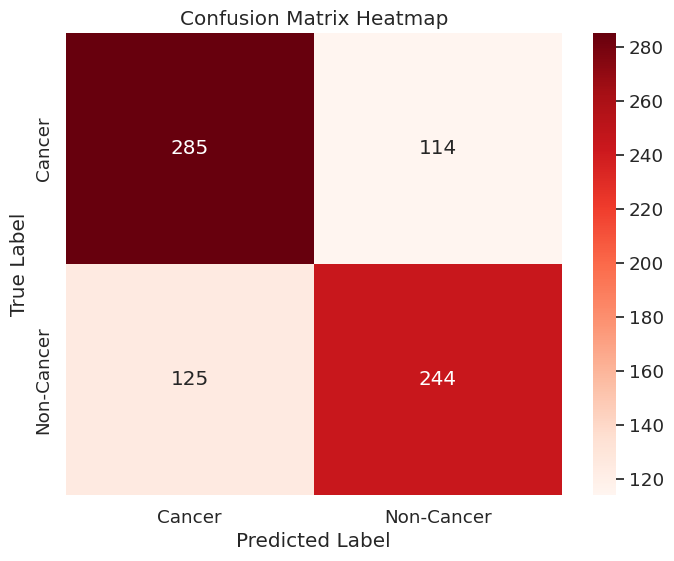

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing import image

# Function to preprocess single image for prediction
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(244, 244))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to predict label of single image
def predict_label(image_path):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)
    if predictions[0][0] >= 0.5:
        return "NONCANCER"
    else:
        return "CANCER"

# Path to test directory
test_dir = "/content/val"

# List to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate through subdirectories in test directory
for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir, label)
    if os.path.isdir(label_dir):
        for filename in os.listdir(label_dir):
            image_path = os.path.join(label_dir, filename)
            true_labels.append(label)  # Assign true label based on subdirectory name
            predicted_label = predict_label(image_path)
            predicted_labels.append(predicted_label)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Cancer', 'Non-Cancer'], yticklabels=['Cancer', 'Non-Cancer'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

1/1 [==============================] - 0s 86ms/step


<Figure size 800x800 with 0 Axes>

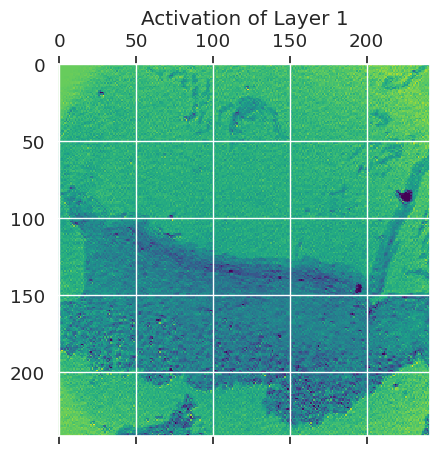

<Figure size 800x800 with 0 Axes>

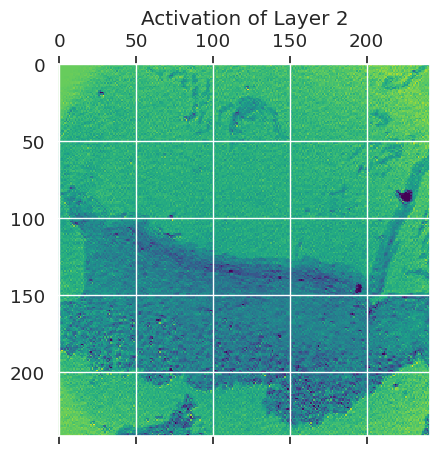

<Figure size 800x800 with 0 Axes>

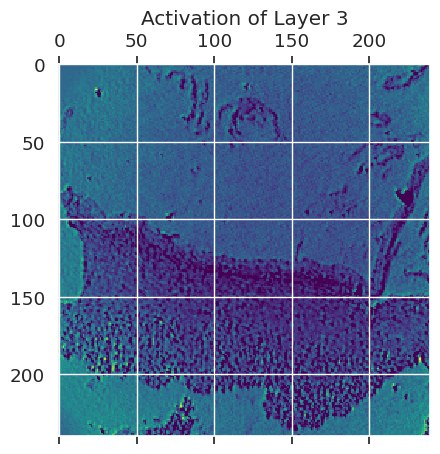

<Figure size 800x800 with 0 Axes>

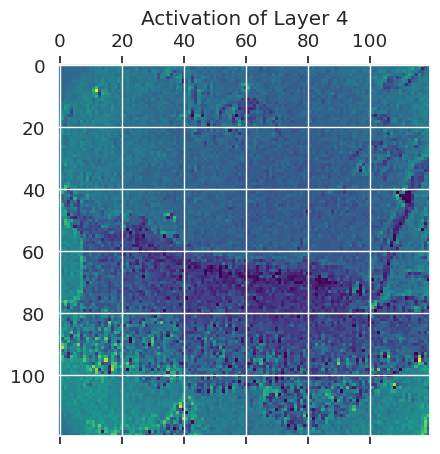

<Figure size 800x800 with 0 Axes>

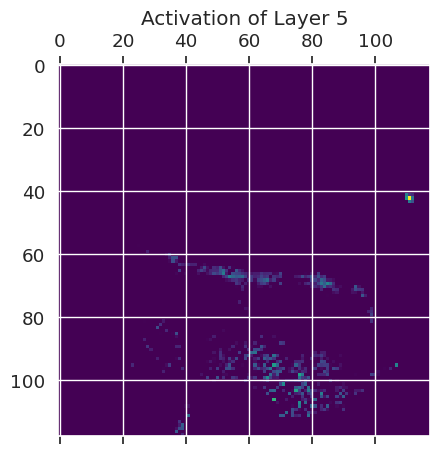

<Figure size 800x800 with 0 Axes>

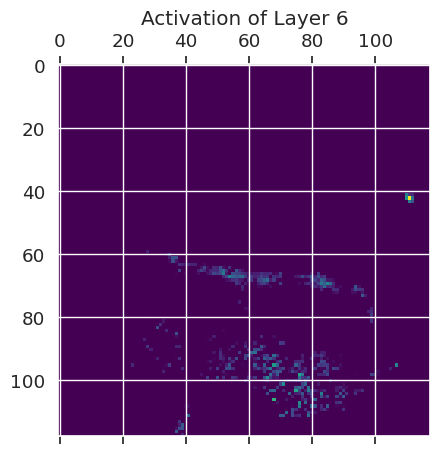

<Figure size 800x800 with 0 Axes>

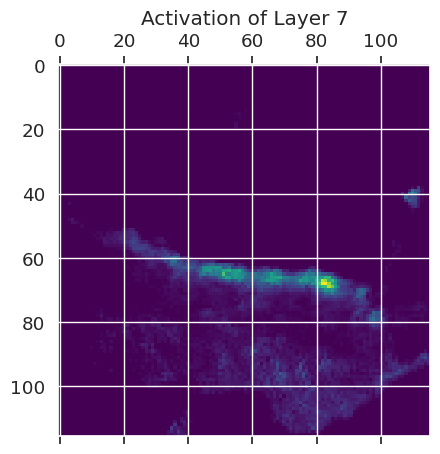

<Figure size 800x800 with 0 Axes>

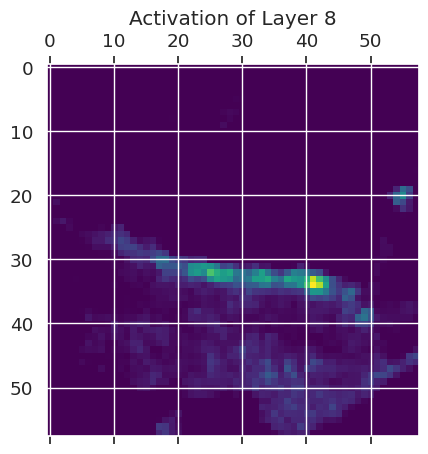

1/1 [==============================] - 0s 31ms/step
Model Prediction: Non-Cancer


In [ ]:
from keras.models import Model

# Choose a sample image path
sample_image_path = "/content/Dataset/NONCANCER/Normal_100x_19.jpg"

# Load the sample image and preprocess it
sample_image = preprocess_image(sample_image_path)

# Create a model that outputs the activations of intermediate layers
layer_outputs = [layer.output for layer in model.layers[:8]]  # Choose the number of layers you want to visualize
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Get the activations of intermediate layers for the sample image
activations = activation_model.predict(sample_image)

# Visualize the feature maps for each layer
for i, activation in enumerate(activations):
    plt.figure(figsize=(8, 8))
    plt.matshow(activation[0, :, :, 0], cmap='viridis')  # Choose the channel you want to visualize
    plt.title(f'Activation of Layer {i+1}')
    plt.show()

# Compare the feature maps to the model's prediction
prediction = model.predict(sample_image)
if prediction[0][0] >= 0.5:
    print("Model Prediction: Non-Cancer")
else:
    print("Model Prediction: Cancer")


In [ ]:
acc=model.evaluate_generator(test_data)[1]
# print(model.evaluate_generator(train_data))
print("The accuracy of our model is" ,acc*100)

The accuracy of our model is 72.91666865348816
